## Example curve prediction script
In this notebook we will try to predict the function coefficients.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from prettytable import PrettyTable
%matplotlib widget

from generate_TF import GenerateTF

# from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F


In [2]:
def scale(X):
    return (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

def descale(X, X_old):
    return (X_old.max(axis=0) - X_old.min(axis=0)) * X + X_old.min(axis=0)

# plot train and validation loss
%matplotlib widget

def plot_loss(loss, val_loss, epoch=(-1, -1)):
    fig = plt.figure()

    if epoch[0] == -1:
        start_idx = 0
    else:
        start_idx = epoch[0]

    if epoch[1] == -1:
        end_idx = len(loss)
    else:
        end_idx = epoch[1]
    loss = loss[start_idx: end_idx]
    val_loss = val_loss[start_idx: end_idx]
    plt.plot(np.arange(start_idx, end_idx), loss, label='train')
    plt.plot(np.arange(start_idx, end_idx), val_loss, label='validation')
    plt.title('Model Accuracy')
    plt.ylabel(criterion_name)
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
    plt.close()


In [181]:
# This is only to verify that the scaling works
x = np.arange(-5, 5, dtype=float).reshape((-1, 2))
xnew = scale(x[::2])
print(x)
print(descale(xnew, x))
# assert np.array_equal(x, descale(x, scale(x)))

[[-5. -4.]
 [-3. -2.]
 [-1.  0.]
 [ 1.  2.]
 [ 3.  4.]]
[[-5. -4.]
 [-1.  0.]
 [ 3.  4.]]


In [4]:
# Load the data
df = pd.read_pickle('./data/transfer-functions-82000.pkl')
df.head()

,phi,g_oo,x,y
0,-20.0,0.000100,"[-1619443.0, -1614543.0211800302, -1609643.042...","[-22.425862483348567, -34.50558003150795, -39...."
1,-20.0,0.000621,"[-1619443.0, -1614543.0211800302, -1609643.042...","[-17.111296708758623, -19.276097087349733, -21..."
2,-20.0,0.001142,"[-1619443.0, -1614543.0211800302, -1609643.042...","[-37.10041261060839, -21.007891272269745, -20...."
3,-20.0,0.001663,"[-1619443.0, -1614543.0211800302, -1609643.042...","[-23.37838521227782, -24.835608713413627, -24...."
4,-20.0,0.002184,"[-1619443.0, -1614543.0211800302, -1609643.042...","[-21.79184944021594, -28.996907099851697, -27...."


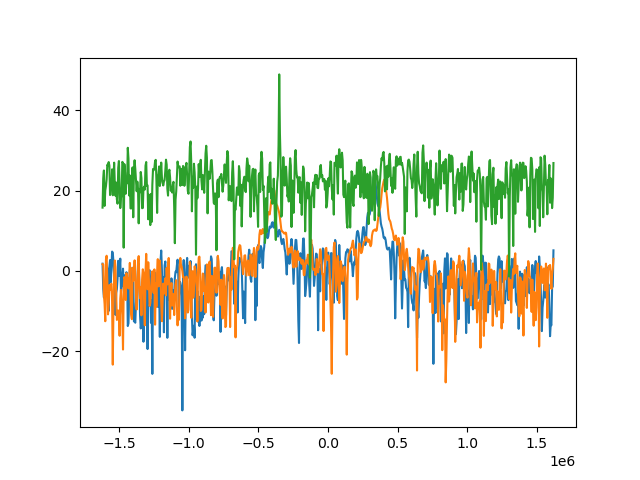

In [5]:
# Visualize the data
for index, row in df.sample(n=3).iterrows():
    y = row['y']
    x = row['x']
    plt.plot(x, y)
plt.show()

In [6]:
# Extract the target variables
param_a = df.pop('phi')
param_b = df.pop('g_oo')

# All x should be equal
x = df.iloc[0].x.astype(np.float32)
df.drop(columns='x', inplace=True)

In [182]:
# target is the target vector
target = np.array((param_a, param_b), dtype=np.float32).T
# scaled_target = scale(target)
target_scaler = preprocessing.StandardScaler().fit(target)
# print(target_scaler.mean_)
# print(target_scaler.scale_)
scaled_target = target_scaler.transform(target)
# target = torch.tensor(target, dtype=torch.float32)
print(target[5:15])
# scaler_target = preprocessing.MinMaxScaler()
scaled_target = torch.tensor(scaled_target)
print(scaled_target[5:15])

[[-2.0000000e+01  2.7052632e-03]
 [-2.0000000e+01  3.2263158e-03]
 [-2.0000000e+01  3.7473685e-03]
 [-2.0000000e+01  4.2684209e-03]
 [-2.0000000e+01  4.7894735e-03]
 [-2.0000000e+01  5.3105261e-03]
 [-2.0000000e+01  5.8315787e-03]
 [-2.0000000e+01  6.3526314e-03]
 [-2.0000000e+01  6.8736840e-03]
 [-2.0000000e+01  7.3947366e-03]]
tensor([[-1.6903, -0.7804],
        [-1.6903, -0.6070],
        [-1.6903, -0.4336],
        [-1.6903, -0.2601],
        [-1.6903, -0.0867],
        [-1.6903,  0.0867],
        [-1.6903,  0.2601],
        [-1.6903,  0.4336],
        [-1.6903,  0.6070],
        [-1.6903,  0.7804]])


In [183]:
# Only the input points have been left
df.head()

,y
0,"[-22.425862483348567, -34.50558003150795, -39...."
1,"[-17.111296708758623, -19.276097087349733, -21..."
2,"[-37.10041261060839, -21.007891272269745, -20...."
3,"[-23.37838521227782, -24.835608713413627, -24...."
4,"[-21.79184944021594, -28.996907099851697, -27...."


In [184]:
values = np.zeros((len(df), len(df.iloc[0,0])), dtype=np.float32)
# print(values.shape)
for index, row in df.iterrows():
    values[index, :] = row.values[0]
print(values.shape)
print(type(values))

(82000, 662)
<class 'numpy.ndarray'>


In [185]:
# Convert data to torch tensor
data_scaler = preprocessing.StandardScaler().fit(values)
# scaled_values = scale(values)
scaled_values = data_scaler.transform(values)
# scaled_values = values
# print(data_scaler.mean_)
# print(data_scaler.scale_)
data = torch.tensor(scaled_values)
# data = torch.tensor(values, dtype=torch.float32)
print(data)

tensor([[-1.2695, -2.2140, -2.7280,  ..., -0.9453, -1.3646, -2.3427],
        [-0.7820, -0.7954, -0.9861,  ..., -0.7045, -0.7330, -2.1319],
        [-2.6156, -0.9567, -0.9385,  ..., -0.9320, -1.0220, -1.4074],
        ...,
        [ 0.1626,  0.3590,  0.2569,  ..., -0.3814, -0.2362,  0.3938],
        [-0.3497,  0.5654,  0.5511,  ...,  0.5762,  0.7127,  0.0781],
        [-0.0635,  0.6010,  0.6840,  ...,  0.0100,  0.1177,  0.4430]])


In [186]:
# Split in train and test
X_train, X_test, y_train, y_test = train_test_split(data, scaled_target, test_size=0.2, random_state=2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([65600, 662])
torch.Size([16400, 662])
torch.Size([65600, 2])
torch.Size([16400, 2])


In [292]:
# Define the network architecture

class Net(nn.Module):
    def __init__(self, n_inputs, n_outputs, activation_func=F.gelu,
                 hidden_1=140, hidden_2=110, hidden_3=0,
                 kernel_size=10, stride=10, trim_edges=120):
        super(Net, self).__init__()
        self.activate = activation_func

        # A layer that trims out the edges
        self.center = nn.ConstantPad1d(-trim_edges, 0)
        n_inputs -= 2 * trim_edges
        # An avgpooling layer to smoothen the curve
        padding = 0
        n_pool_out = (n_inputs + 2 * padding - kernel_size)//stride +1
        self.pool1 = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=padding)

        # linear layer (n_pool_out -> hidden_1)
        self.fc1 = nn.Linear(n_pool_out, hidden_1)

        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(hidden_1, hidden_2)

        # linear layer (n_hidden -> n_outputs)
        if hidden_3 > 0:
            self.fc3 = nn.Linear(hidden_2, hidden_3)
            self.fc4 = nn.Linear(hidden_3, n_outputs)
        else:
            self.fc3 = nn.Linear(hidden_2, n_outputs)
            self.fc4 = None

        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # remove some points from the edges
        x = self.center(x)

        # This performs the average pooling layer
        x = self.pool1(x)

        # add hidden layer, with relu activation function
        x = self.activate(self.fc1(x))

        # add dropout layer
        x = self.dropout(x)

        # add hidden layer, with relu activation function
        x = self.activate(self.fc2(x))

        # add dropout layer
        x = self.dropout(x)

        if self.fc4:
            x = self.dropout(self.activate(self.fc3(x)))
            # add outputlayer
            x = self.fc4(x)
        else:
            # add output layer
            x = self.fc3(x)

        return x


    def get_accuracy(self, pred_arr, original_arr, pct=0.1):
        n_correct = torch.sum((torch.abs(pred_arr-original_arr) < torch.abs(pct * original_arr)))
        acc = (n_correct.item() * 100.0 / len(original_arr))
        return acc


    def save(self, name='model.pt'):
        torch.save(self.state_dict(), name)


    def train_net(self, optimizer, criterion, X_train, y_train, X_test, y_test, num_epochs=100):
        l_train_loss=[]
        l_train_accuracy=[]
        l_test_loss=[]
        l_test_accuracy=[]
        min_test_loss = np.Inf
        for epoch in range(num_epochs):
            # put the model in training mode
            self.train()

            # clear the gradients of all optimized variables
            optimizer.zero_grad()

            # forward pass: compute predicted outputs by passing inputs to the model
            output_train = model(X_train)

            # l_train_accuracy.append(self.get_accuracy(output_train, y_train))

            #calculate the loss
            train_loss = criterion(output_train, y_train)
            l_train_loss.append(train_loss.item())

            #backward pass: compute gradient of the loss with respect to model parameters
            train_loss.backward()

            # perform a single optimization step (parameter update)
            optimizer.step()

            with torch.no_grad():
                output_test = model(X_test)
                test_loss = criterion(output_test, y_test)
                l_test_loss.append(test_loss.item())
                # l_test_accuracy.append(self.get_accuracy(output_test, y_test))

            if l_test_loss[-1] < min_test_loss:
                print(f"Epoch {epoch+1}/{num_epochs}: Test loss decreased ({min_test_loss:.6f} --> {l_test_loss[-1]:.6f}), saving model.")
                self.save('model.pt')
                min_test_loss = l_test_loss[-1]

            if (epoch + 1) % 50 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {l_train_loss[-1]:.4f}, Test Loss: {l_test_loss[-1]:.4f}")

        return l_train_loss, l_train_accuracy, l_test_loss, l_test_accuracy


In [311]:
# Initialize model, loss function and optimizer

n_inputs = data.shape[1]
n_outputs = scaled_target.shape[1]
model = Net(n_inputs, n_outputs, activation_func=F.gelu,
            hidden_1=140, hidden_2=110, hidden_3=0,
            kernel_size=10, stride=10, trim_edges=120)
print(model)

# specify loss function (regression)
criterion = nn.MSELoss(); criterion_name = 'MSE'
# criterion = nn.L1Loss(); criterion_name = 'MAE'

# specify optimizer (stochastic gradient descent) and learning rate = 0.01
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)
# optimizer = torch.optim.LBFGS(model.parameters(), lr=0.01)

# train the network
train_loss, train_accuracy, test_loss, test_accuracy = model.train_net(
    optimizer, criterion, X_train, y_train, X_test, y_test, 5000)

Net(
  (center): ConstantPad1d(padding=(-120, -120), value=0)
  (pool1): AvgPool1d(kernel_size=(10,), stride=(10,), padding=(0,))
  (fc1): Linear(in_features=42, out_features=140, bias=True)
  (fc2): Linear(in_features=140, out_features=110, bias=True)
  (fc3): Linear(in_features=110, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Epoch 1/5000: Test loss decreased (inf --> 0.787280), saving model.
Epoch 2/5000: Test loss decreased (0.787280 --> 0.622651), saving model.
Epoch 3/5000: Test loss decreased (0.622651 --> 0.516682), saving model.
Epoch 4/5000: Test loss decreased (0.516682 --> 0.380906), saving model.
Epoch 5/5000: Test loss decreased (0.380906 --> 0.279032), saving model.
Epoch 6/5000: Test loss decreased (0.279032 --> 0.259729), saving model.
Epoch 8/5000: Test loss decreased (0.259729 --> 0.236059), saving model.
Epoch 10/5000: Test loss decreased (0.236059 --> 0.204606), saving model.
Epoch 11/5000: Test loss decreased (0.204606 --> 0.195270), sa

KeyboardInterrupt: 

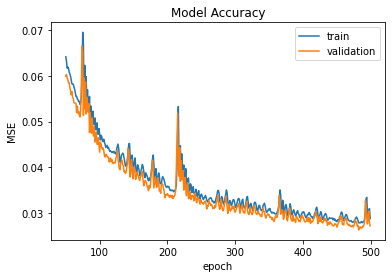

In [312]:
plot_loss(train_loss, test_loss, epoch=(50,-1))


In [299]:
# Hyper parameter tuning
# criterion = nn.L1Loss(); criterion_name = 'MAE'
n_inputs = data.shape[1]
n_outputs = scaled_target.shape[1]
test_results = []
num_epochs = 100
for activ_f, activ_f_name in [(F.relu, 'relu'), (F.relu6, 'relu6'), (F.gelu, 'gelu')]:
    for kernel_size, stride in [(10,10)]:
        for hidden_1 in [140]:
            for hidden_2 in [110]:
                for hidden_3 in [0]:
                    for trim_edges in [120]:
                        print(f"Training net with: activation, kernel_size, stride, h_1, h_2, h_3, trim "
                              f"= ({activ_f_name}, {kernel_size}, {stride},"
                              f"{hidden_1}, {hidden_2}, {hidden_3}, {trim_edges})")
                        model = Net(n_inputs, n_outputs, activation_func=activ_f,
                                    hidden_1=hidden_1, hidden_2=hidden_2, hidden_3=hidden_3,
                                    kernel_size=kernel_size, stride=stride, trim_edges=trim_edges)
                        criterion = nn.MSELoss(); criterion_name = 'MSE'
                        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
                        train_loss, train_accuracy, test_loss, test_accuracy = model.train_net(
                            optimizer, criterion, X_train, y_train, X_test, y_test, num_epochs)
                        test_results.append([activ_f_name, kernel_size, stride, hidden_1, hidden_2, hidden_3,
                                             trim_edges, np.min(test_loss)])
        # plot_loss(train_loss, test_loss, epoch=(10,-1))

Training net with: activation, kernel_size, stride, h_1, h_2, h_3, trim = (relu, 10, 10,140, 110, 0, 120)
Epoch 1/100: Test loss decreased (inf --> 0.819623), saving model.
Epoch 2/100: Test loss decreased (0.819623 --> 0.633835), saving model.
Epoch 3/100: Test loss decreased (0.633835 --> 0.553267), saving model.
Epoch 4/100: Test loss decreased (0.553267 --> 0.403243), saving model.
Epoch 5/100: Test loss decreased (0.403243 --> 0.349038), saving model.
Epoch 7/100: Test loss decreased (0.349038 --> 0.312437), saving model.
Epoch 9/100: Test loss decreased (0.312437 --> 0.217016), saving model.
Epoch 10/100: Test loss decreased (0.217016 --> 0.214875), saving model.
Epoch 11/100: Test loss decreased (0.214875 --> 0.200645), saving model.
Epoch 12/100: Test loss decreased (0.200645 --> 0.186895), saving model.
Epoch 13/100: Test loss decreased (0.186895 --> 0.179410), saving model.
Epoch 14/100: Test loss decreased (0.179410 --> 0.163887), saving model.
Epoch 15/100: Test loss decrea

In [300]:
table = PrettyTable()
table.field_names = ["activation", "kernel size", "stride",
                     "hidden_1", "hidden_2", "hidden_3", "trim_edges", "Min Loss"]
test_results.sort(key=lambda x: x[-1])
for row in test_results:
    table.add_row(row)
# print('kernel_size, stride, Min loss')
print(table)

+------------+-------------+--------+----------+----------+----------+------------+----------------------+
| activation | kernel size | stride | hidden_1 | hidden_2 | hidden_3 | trim_edges |       Min Loss       |
+------------+-------------+--------+----------+----------+----------+------------+----------------------+
|    gelu    |      10     |   10   |   140    |   110    |    0     |    120     | 0.046781137585639954 |
|   relu6    |      10     |   10   |   140    |   110    |    0     |    120     | 0.04978570714592934  |
|    relu    |      10     |   10   |   140    |   110    |    0     |    120     | 0.05272996798157692  |
+------------+-------------+--------+----------+----------+----------+------------+----------------------+


In [313]:
# load model with highest accuracy
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [322]:
# make predictions
random_idx = np.random.choice(np.arange(len(X_test)), size=100, replace=False)
X_validate = X_test[random_idx]
y_validate = y_test[random_idx]


In [323]:
with torch.no_grad():
    yhat = model(X_validate)
X_validate_new = data_scaler.inverse_transform(X_validate.numpy())
yhat_new = target_scaler.inverse_transform(yhat.numpy())
y_validate_new = target_scaler.inverse_transform(y_validate.numpy())

+-----+-------+--------------+--------------+-----------------------+
| idx | param |   original   |    model     |       optimizer       |
+-----+-------+--------------+--------------+-----------------------+
|  0  |  phi  |    -19.0     |  -18.508568  |   -64.94362168370974  |
|  0  |  g_oo | 0.0021842106 | 0.0025756636 | 0.0025722253486944483 |
|  1  |  phi  |     6.0      |   6.603016   |   5.686942538852372   |
|  1  |  g_oo | 0.006873684  | 0.0068168417 |  0.007321874316165141 |
|  2  |  phi  |     0.0      |  0.3022268   |   0.1721021605519458  |
|  2  |  g_oo | 0.0027052632 | 0.003028084  |  0.006083404365216955 |
+-----+-------+--------------+--------------+-----------------------+


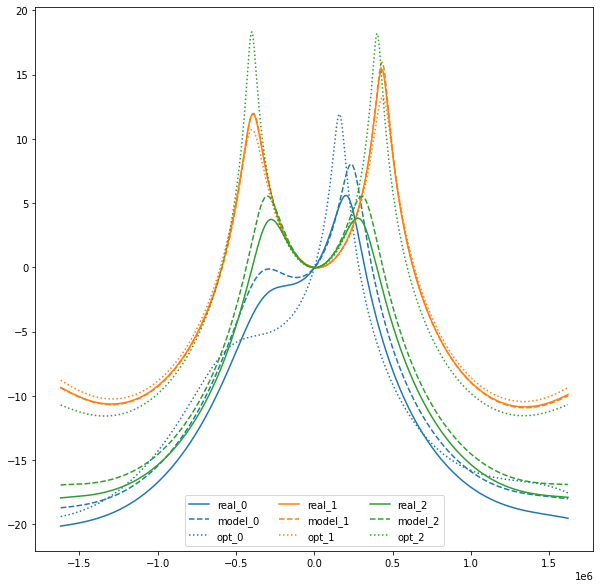

In [324]:
# plot the validation curves
%matplotlib inline

plt.figure(figsize=(10, 10))
gen_tf = GenerateTF(fb_attn_index=3, with_noise=False)
x = gen_tf.frequency.astype(np.float32)

table = PrettyTable()
table.field_names = ["idx", "param", "original", "model", "optimizer"]
# print(table)

for idx in range(3):
    try:
        popt, pcov  = curve_fit(gen_tf, x, X_validate_new[idx])
    except:
        print(f'Scipy curve fit failed for idx: {idx}')
        continue

    # print('Param, Original, Model, Optimizer')
    table.add_row([idx, 'phi', y_validate_new[idx][0], yhat_new[idx][0], popt[0]])
    table.add_row([idx, 'g_oo', y_validate_new[idx][1], yhat_new[idx][1], popt[1]])

    # print('phi', y_validate_new[idx][0], yhat_new[idx][0], popt[0])
    # print('g_oo', y_validate_new[idx][1], yhat_new[idx][1], popt[1])

    p = plt.plot(x, gen_tf(x, *(y_validate_new[idx])), label=f'real_{idx}', ls='-')
    plt.plot(x, gen_tf(x, *(yhat_new[idx])), label=f'model_{idx}', ls='--', color=p[0].get_color())
    plt.plot(x, gen_tf(x, *popt), label=f'opt_{idx}', ls=':', color=p[0].get_color())

print(table)
plt.legend(ncol=3)
plt.show()
plt.close()

In [317]:
def calc_mae_model(yhat, yreal):
    # model.eval()
    # with torch.no_grad():
    #     yhat = model(test_x)
    # new_yhat = descale(yhat.numpy(), target)
    # new_y = descale(test_y.numpy(), target)
    #
    # new_yhat = yhat.numpy()
    # new_y = test_y.numpy()

    return np.abs(np.mean(np.abs(yhat-yreal), axis=0)/ np.max(yreal, axis=0))

def calc_mae_optimize(test_x, test_y):
    gen_tf = GenerateTF(fb_attn_index=3, with_noise=False)
    x = gen_tf.frequency.astype(np.float32)
    coeffs = []
    real = []
    for xi, yi in zip(test_x, test_y):
        try:
            popt, pcov  = curve_fit(gen_tf, x, xi)
        except:
            # print(f'Scipy curve fit failed for idx: {idx}')
            continue
        coeffs.append(popt)
        real.append(yi)
    yhat = np.array(coeffs)
    real = np.array(real)
    return np.abs(np.mean(np.abs(yhat - real), axis=0)/ np.max(real, axis=0))

In [325]:
mae_model = calc_mae_model(yhat_new, y_validate_new)
mae_optimize = calc_mae_optimize(X_validate_new, y_validate_new)
print('Model mae: ', mae_model)
print('Optimize mae: ', mae_optimize)

Model mae:  [0.05891393 0.02399058]
Optimize mae:  [0.38390938 1.53249369]


In [ ]:
# evaluate our model
# def evaluate_model(X, y):
#     results = list()
#     n_inputs = X.shape[1]
#     n_outputs = y.shape[1]
#         # define evaluation procedure
#     cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
#     # enumerate folds
#     for train_ix, test_ix in cv.split(X):
#         # prepare data
#         X_train, X_test = tf.gather(X, train_ix), tf.gather(X, test_ix)
#         y_train, y_test = tf.gather(y, train_ix), tf.gather(y, test_ix)
#
#         # X_train, X_test = tf_data[train_ix], tf_data[test_ix]
#         # y_train, y_test = tf_target[train_ix], tf_target[test_ix]
#         # define model
#         model = get_model(n_inputs, n_outputs)
#         # fit model
#         model.fit(X_train, y_train, verbose=0, epochs=100)
#         # evaluate model on test set
#         mae = model.evaluate(X_test, y_test, verbose=0)
#         # store result
#         print('>%.3f' % mae)
#         results.append(mae)
#     print('MAE: %3f (%.3f)' % (np.mean(results), np.std(results)))
#     return results